### Salish Sea Oil Spill Scenarios

This notebook describes oil particle tracking for spill scenarios in the Salish Sea developed in conjunction with the Canadian Department of Fisheries and Oceans (DFO). The code is for translating particle tracking from *ocean parcels* using the *Salish Sea Cast* grid into input forcing files for *Atlantis* and resulting in oil dispersal on the *Salish Sea Atlantis Model* box grid.

In [1]:
import sys
import os
import math
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import Image
from netCDF4 import Dataset
from shapely.geometry import Point
from pathlib import Path
from pprint import pprint
from parcels import AdvectionRK4, VectorField, Variable
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field
import numpy as np
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_2182bdef-4f72-4fca-830f-792967c40c35.so


In [2]:
# Data Paths
currents = Path('/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/')
winds = Path('/ocean/rlovindeer/Atlantis/Physics/Wind/')
sea_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc')
air_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc')
fraser_discharge = Path('/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow')
tides = '/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Tides/'

### Spill Scenarios
Scenarios are based on discussion with DFO & Transport Canada. See [this documented](https://docs.google.com/spreadsheets/d/17HgaXoKG5b0zkigri6Vdw7fNviDKVzzTVrbpVVRrCjk/edit?usp=sharing) for full scenario descriptions, including spill locations, and type and volume of spill.

In [3]:
# Spill release times
release_start = '2020-07-01'  ## winter starts in December, Summer in Jul - Aug
release_end = '2020-07-02'
release_YYYYMM = '2020-07'
spill_volume = 2e6 # L

In [4]:
# Oil type properties & spill location selection

bitumen = {
    "Weight": 1021.9,       # g/L
    "Naphthalene": 0.024,   # mg/g oil
    "Phenanthrene": 0.017,
    "Pyrene": 0.010,
    "Benzo": 0.003,
}

BunkerC = {
    "Weight": 1017.8,
    "Naphthalene": 0.680,
    "Phenanthrene": 0.796,
    "Pyrene": 0.266,
    "Benzo": 0.056,
}

Diesel = {
    "Weight": 841.6,
    "Naphthalene": 3.664,
    "Phenanthrene": 1.000,
    "Pyrene": 0.000,
    "Benzo": 0.000,
}

Crude = {
    "Weight": 933.6,
    "Naphthalene": 0.654,
    "Phenanthrene": 0.327,
    "Pyrene": 0.013,
    "Benzo": 0.002,
}

fuel_type = {
    "bitumen" : bitumen,
    "BunkerC" : BunkerC,
    "Diesel" : Diesel,
    "Crude" : Crude,
}

file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",}

print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 5b_Turn_Point_Diluted_bitumen


## Creating particle movement through Ocean Parcels

In [5]:
#Kernels
def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this needs to be added to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2
            
def BeachTesting(particle, fieldset, time):
    """ Testing if particles are on land. if 'yes' particle will be removed"""
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        #print(u, v)
        if u == 0 and v == 0:
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(0 * dt/field_decay_value) #math.exp(-1.0 * dt/field_decay_value)
    particle.decay_value = particle.decay_value * decay

In [6]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
u_current = sorted([p for p in currents.glob(str(release_YYYYMM) + '*URaw_variables.nc')])
v_current = sorted([p for p in currents.glob(str(release_YYYYMM) + '*VRaw_variables.nc')])

filenames = {
    'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
    'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True);
print('fieldset created from_nemo')

fieldset.add_constant('decay', 1.0 * 3600.0);
print('decay constant added')

fieldset created from_nemo
decay constant added


In [7]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_paths = sorted([p for p in winds.glob(str(release_YYYYMM) + '*Wind_variables.nc')])
wind_filenames = {'lon': os.fspath(air_grid),'lat': os.fspath(air_grid),'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

pprint(wind_filenames)

{'data': [PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-06_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-12_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-18_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-24_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2020-07-30_Wind_variables.nc')],
 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc',
 'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'}


In [8]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [9]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [10]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 1
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [11]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 100
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario[file_id] + ".shp"
release_depth = -0.1
release_start_time = np.datetime64(release_start)
release_end_time = np.datetime64(release_end)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')


setting up particles


### Salish Sea Conditions during the scenario run
Tide data is taken from [DFO-Pacific website](https://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07735) at the nearest tide gauge. 
Surface winds are taken from hourly atmospheric field values from the Environment Canada High Resolution Deterministic Prediction System (HRDPS) atmospheric forcing model, and used to force the surface winds for Ocean Parcels.
Discharge from the Fraser River (m^3) is acquired from Salish Sea Cast.

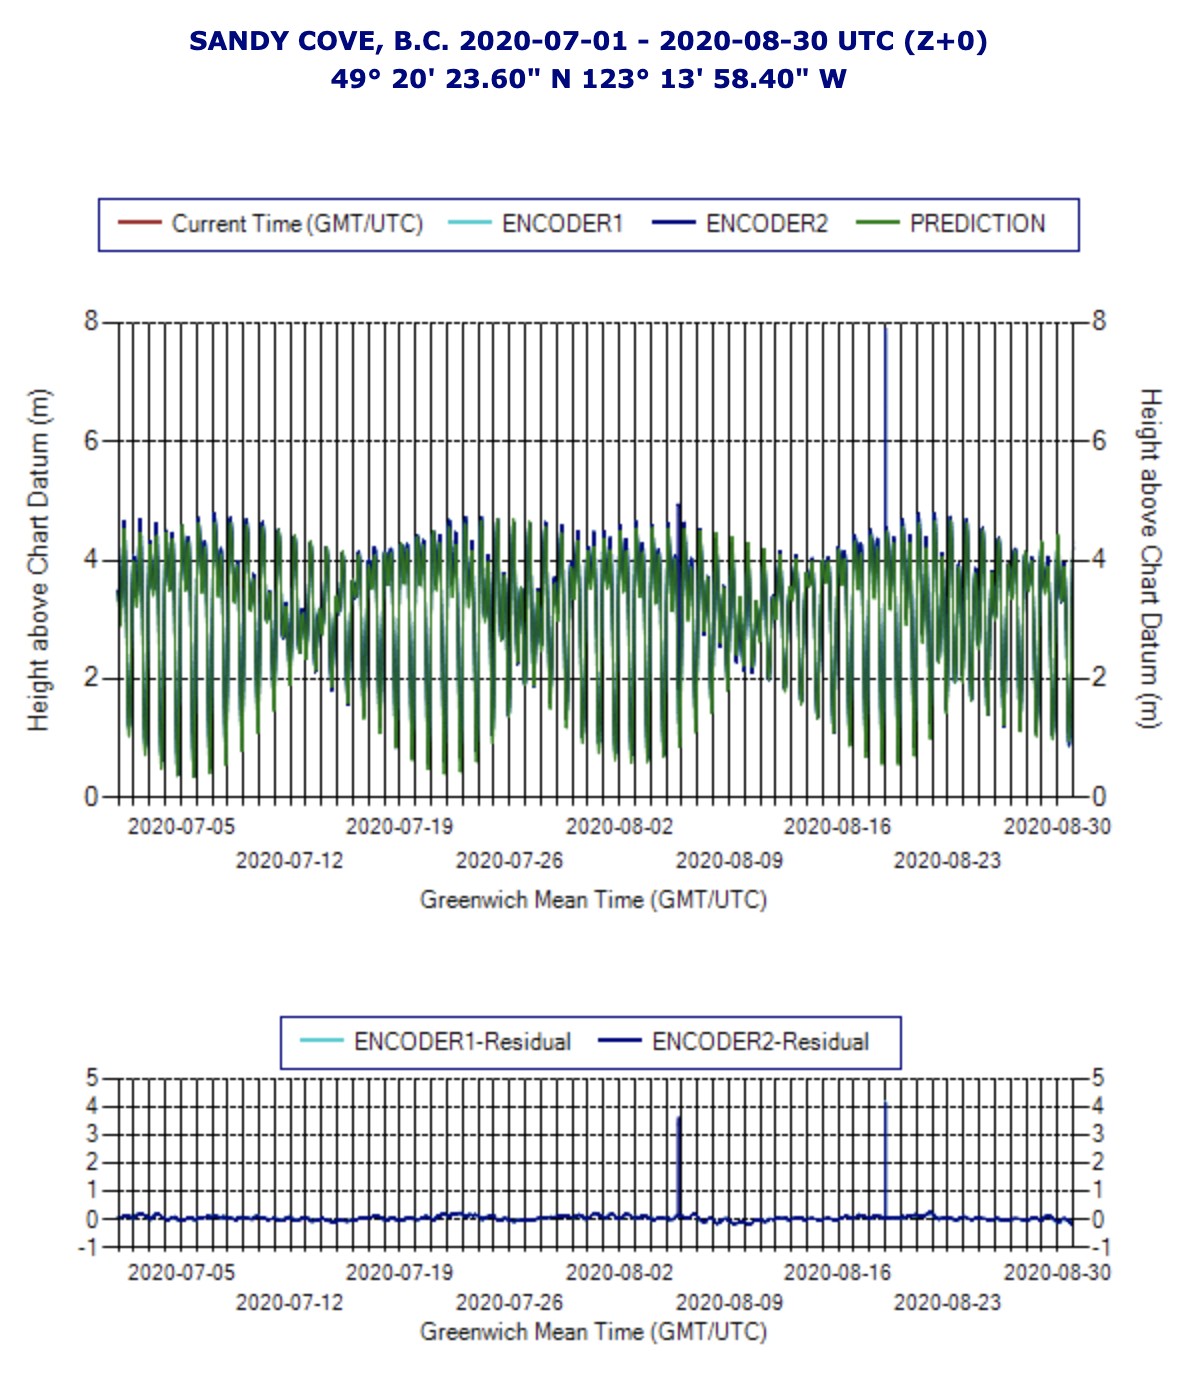

In [12]:
# Tides
Tide_location = 'SandyCove_'
tide_filename = tides + 'Tides_' + Tide_location + str(release_start) +'.png'
Image(filename= tide_filename)

# Winds
place = 'Sand Heads'
#lat_lon = places.PLACES[place]['GEM2.5 grid ji']
#lat_lon

surface_wind = winds.glob(str(release_start) + '_Wind_variables.nc')
print(surface_wind)

wind_velocity = xr.open_dataset(surface_wind)

uvelocity = wind_velocity.u_wind.isel(gridX=135, gridY=151).data
vvelocity = wind_velocity.v_wind.isel(gridX=135, gridY=151).data
wind_speed, winds = wind_tools.wind_speed_dir(uvelocity, vvelocity)

fig, ax = plt.subplots(1,1, figsize = (14,6))

ax.plot(wind_velocity.time,wind_speed, color = 'darkblue', linewidth = 2)
ax.set_title('wind speed at '+place+' (m/s)', fontsize = 12)
ax.tick_params(labelsize=12)

In [13]:
# Fraser River Discharge 
# format is YYYY MM DD m^3

df = pd.read_csv(fraser_discharge, skiprows=35000, names=['date_flow']) 
df = pd.DataFrame(df.date_flow.str.split(' ',3).tolist(),columns = ['Y','M','D','flow_m^3'])
df1 = df.loc[df['Y'] == '2020']
df2 = df1.loc[df['M'] == '07']
df3 = df2.loc[df['D']== '01']
df3

,Y,M,D,flow_m^3
4571,2020,07,01,9.816528e+03


In [14]:

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time);
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth);

#print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle);
beaching_kernel = pset.Kernel(BeachTesting);
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4);

# Adding to the main kernel
my_kernel = AdvectionRK4 + decay_kernel + ForcingWind_kernel + beaching_kernel;

output_file_name = scenario[file_id] + str(release_start_time) + '_OP.nc'
print(output_file_name)

-261000.0
100
100
Using shapefile /ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/5b_Turn_Point_Diluted_bitumen.shp
Number of sites :  1
Up to 0 of 1
80
100
Sucessfully seeded particles

num_attempts = 2
[-123.29342181743614, -123.29308906571126, -123.29331391769186, -123.29342967807801, -123.29367213484532, -123.29322765621787, -123.29364427002147, -123.29273589844243, -123.29375256140635, -123.29293599436784, -123.2934616546045, -123.29338335532181, -123.29266825116741, -123.2943451858446, -123.2928542047529, -123.2929631309421, -123.29277942014751, -123.29292112731557, -123.29359648571949, -123.29295838609143, -123.29428289559226, -123.29323960240134, -123.29263010660989, -123.2934757478005, -123.29369012056402, -123.2939903332198, -123.29297097706512, -123.29360714377957, -123.29338257654626, -123.29448186484314, -123.29328417344985, -123.29329525299856, -123.29328557645024, -123.29263194828697, -123.29315580384579, -123.29380042864285, -123.2936453805364, -1

In [15]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove '5b_Turn_Point_Diluted_bitumen2020-07-01_oil_disperse.nc': No such file or directory


INFO: Temporary output files are stored in out-YTKRUZVE.
INFO: You can use "parcels_convert_npydir_to_netcdf out-YTKRUZVE" to convert these to a NetCDF file during the run.
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:12:20 Time:  0:12:20


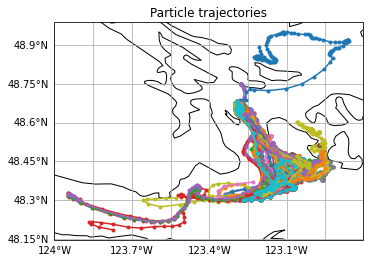

particle trajectories completed


In [16]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*6),   # total length of the run
             dt = timedelta(minutes = 60),      # timestep of the kernel
             output_file = output_file)         # file name and the time step of the outputs
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')

## Parcing Ocean Parcels output into Atlantis input files


In [17]:
SalishSea_shapefile = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(SalishSea_shapefile)

In [18]:
numLayers = 7;
numSites = data_df.shape[0]
numTargetSites = numSites

outputDT = 60*60*12 #12 hours

stepsPerDay = int(86400.0/ outputDT);
numStepsPerDT = stepsPerDay;
numStepsPerDT = int(outputDT/3600.0)

debug = False

inputFileName = output_file_name
pfile = xr.open_dataset(str(inputFileName), decode_cf=True)

In [19]:
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
z = np.ma.filled(pfile.variables['z'], np.nan)
probs = np.ma.filled(pfile.variables['decay_value'], np.nan)

numParticles = lon.shape[0]

trackDates = [];

for i in range(0,numParticles):
    #print(time[i][0])
    trackDates.append(time[i][0]);

RDiff = max(trackDates) - min(trackDates);

minDate = np.datetime64(release_start+"T00:30:00");
ts = pd.to_datetime(str(minDate));
d = ts.strftime('%Y-%m-%d %H:%M:%S');
print(d)

2020-07-01 00:30:00


In [20]:
numReleaseDays = 1;
numReleaseSteps = numReleaseDays * stepsPerDay;
trackLength = len(lon[0]);

print('trackLength = ' + str(trackLength))
print('numStepsPerDT = ' + str(numStepsPerDT))

numSteps = int(trackLength / numStepsPerDT);

trackLength = 145
numStepsPerDT = 1


In [21]:
# Create the netcdf output file for Atlantis

netcdfFileName = "Atlantis_" + scenario[file_id] + str(release_start_time) + ".nc"

try:
    os.remove(netcdfFileName)
except: 
    pass

ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)

# Dimensions
time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numTargetSites)
z = ncfile.createDimension("z", numLayers)

# Variables
times = ncfile.createVariable("time","f4",("t",))
oil = ncfile.createVariable("oil","f4",("t", "b", "z"))
Naphthalene = ncfile.createVariable("Naphthalene","f4",("t", "b", "z"))
Phenanthrene = ncfile.createVariable("Phenanthrene","f4",("t", "b", "z"))
Pyrene = ncfile.createVariable("Pyrene","f4",("t", "b", "z"))
Benzo = ncfile.createVariable("Benzo","f4",("t", "b", "z"))

# Attributes
times.units = "seconds since 1950-01-01 00:00:00 +10"
times.dt = outputDT
times.long_name = "time"

oil.units = "gOIL/m^3"
oil.long_name = "Concentration of oil"

Naphthalene.units = "mgPAH/m^3"
Naphthalene.long_name = "Naphthalene"
Naphthalene.missing_value = 0.0
Naphthalene.valid_min = 0.0
Naphthalene.valid_max = 10000000000.0

Phenanthrene.units = "mgPAH/m^3"
Phenanthrene.long_name = "Phenanthrene"
Phenanthrene.missing_value = 0.0
Phenanthrene.valid_min = 0.0
Phenanthrene.valid_max = 10000000000.0

Pyrene.units = "mgPAH/m^3"
Pyrene.long_name = "Pyrene"
Pyrene.missing_value = 0.0
Pyrene.valid_min = 0.0
Pyrene.valid_max = 10000000000.0

Benzo.units = "mgPAH/m^3"
Benzo.long_name = "Benzo(a)pyrene"
Benzo.missing_value = 0.0
Benzo.valid_min = 0.0
Benzo.valid_max = 10000000000.0

# Populate variables with data
timeData = np.arange(0,(numSteps + numReleaseSteps)*outputDT,outputDT)
times[:] = timeData;

boxDispersal = np.zeros((numSteps + numReleaseSteps, numTargetSites));

In [23]:
for partIndex in range(0, numParticles):

    trackDateDiff = trackDates[partIndex] - minDate;
    trackDateDiff = trackDateDiff/ np.timedelta64(1, 's')

    timeOffset = int(abs((trackDateDiff /outputDT)));

    for stepIndex in range(0, numSteps):
        timeValue = stepIndex + timeOffset

        partLon = lon[partIndex][stepIndex * numStepsPerDT];
        partLat = lat[partIndex][stepIndex * numStepsPerDT];
        partProb = probs[partIndex][stepIndex * numStepsPerDT];

        matchFound = 0;

        for targetIndex in range(0, numTargetSites):

            path = data_df.iloc[targetIndex].geometry
            checks = path.contains(Point(partLon, partLat));

            if checks:
                boxDispersal[timeValue][targetIndex] = boxDispersal[timeValue][targetIndex] + partProb;

                # uncomment line below to ignore particle decay during debugging.
                #boxDispersal[timeValue][targetIndex] = boxDispersal[timeValue][targetIndex] + 1.0

                matchFound = 1
                if debug:
                    print('At time ' + str(timeValue) + ' Particle (' + str(partIndex) + ') in box ' + str(data_df.iloc[targetIndex].BOX_ID))


                break;

        if matchFound == 0:
            if debug:
                print('No match for particle')
                print(partLon, partLat)


        #break

oil[:, :, 5] = boxDispersal * fuel_type[scenario[file_id].split(sep = '_')[-1]]["Weight"] * spill_volume;
Naphthalene[:, :, :] = oil[:, :, :] * fuel_type[scenario[file_id].split(sep = '_')[-1]]["Naphthalene"];
Phenanthrene[:, :, :] = oil[:, :, :] * fuel_type[scenario[file_id].split(sep = '_')[-1]]["Phenanthrene"];
Pyrene[:, :, :] = oil[:, :, :] * fuel_type[scenario[file_id].split(sep = '_')[-1]]["Pyrene"];
Benzo[:, :, :] = oil[:, :, :] * fuel_type[scenario[file_id].split(sep = '_')[-1]]["Benzo"];

ncfile.close()

## Animating Oil Dispersal Scenario in the Salish Sea Atlantis Model

In [24]:
boxes = data_df['BOTZ']
land_boxes = boxes==0
land_boxes = data_df.index[land_boxes]

numReleaseDays = RDiff
print('numReleaseDays = ' + str(numReleaseDays))

numReleaseDTS = int(abs(numReleaseDays/np.timedelta64(1, 'h')));
totalNumOfTS = int(numReleaseDTS + trackLength);
print('totalNumOfTS = ' + str(totalNumOfTS))
print('trackLength = ' + str(trackLength))
print(numParticles)

numReleaseDays = 82800000000000 nanoseconds
totalNumOfTS = 168
trackLength = 145
100


In [25]:
trackLonsPadded = np.zeros((int(numParticles), totalNumOfTS));
trackLatsPadded = np.zeros((int(numParticles), totalNumOfTS));
particlesAge = np.zeros((int(numParticles), totalNumOfTS));

for trackIndex in range(0,numParticles):

    #print(trackDates[trackIndex])
    #print(minDate)
    trackDateDiff = trackDates[trackIndex] - minDate

    #print(trackDateDiff/np.timedelta64(1, 'h'))

    trackNumsToPad = int(trackDateDiff/np.timedelta64(1, 'h'))
    #print(trackNumsToPad)

    trackLonsPadded[trackIndex][0:trackNumsToPad] = 0;
    trackLatsPadded[trackIndex][0:trackNumsToPad] = 0;

    trackLonsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lon[:][trackIndex];
    trackLatsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lat[:][trackIndex];

numSteps = int(trackLength / numStepsPerDT);

In [27]:
savefile_prefix = 'boxes'

pfile = xr.open_dataset(str(netcdfFileName), decode_cf=True)
print(pfile)

time = np.ma.filled(pfile.variables['time'], np.nan)

oil = np.ma.filled(pfile.variables['Naphthalene'], np.nan)
num_steps = time.shape[0]
#print(num_steps)

<xarray.Dataset>
Dimensions:       (t: 169, b: 130, z: 7)
Dimensions without coordinates: t, b, z
Data variables:
    time          (t) datetime64[ns] ...
    oil           (t, b, z) float32 ...
    Naphthalene   (t, b, z) float32 ...
    Phenanthrene  (t, b, z) float32 ...
    Pyrene        (t, b, z) float32 ...
    Benzo         (t, b, z) float32 ...


In [28]:
# Creating statis figures with a log scale

_cmap = cm.coolwarm
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, num_steps):

    plon = trackLonsPadded[:, time_index]
    plat = trackLatsPadded[:, time_index]

    plon = plon[plon<0]
    plat = plat[plat>0]
    time_oil = oil[time_index]

    data_df['oil'] = time_oil
    data_df.loc[land_boxes, 'oil'] = 1

    ax = data_df.plot(figsize=(9, 15), column = 'oil', cmap = _cmap, norm=colors.SymLogNorm(
        linthresh=0.000001, linscale=0.000001,
        vmin=-0.0001, vmax=1e10, base=10),
        legend=True, legend_kwds={'label': "Relative Oil Concentration"
        },)

    land_df.plot(ax=ax, color='white')
    ax.scatter(plon, plat, s=0.0001, color='lightgrey', zorder=20)

    ax.set_title(time[time_index])

    plot_name = savefile_prefix + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

ValueError: Wrong number of items passed 7, placement implies 1

In [ ]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into loop
anim_name = 'Oil_Scenario_' + scenario[file_id] + str(release_start_time) +'c.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

file_name_str = ' '.join(file_names);
os.system('rm ' + file_name_str);

In [ ]:
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))